In [1]:
MODEL_NAME = "LovrOP/model_zavrsni_19"
IMAGE_SIZE = 480

In [2]:
id2label = {
    0: "1dio",
    1: "2dio",
    2: "3dio",
    3: "4dio",
    4: "5dio",
    5: "6dio",
    6: "7dio",
    7: "8dio",
    8: "9dio",
    9: "10dio"
}


In [3]:
label2id = {
    "1dio": 0,
    "2dio": 1,
    "3dio": 2,
    "4dio": 3,
    "5dio": 4,
    "6dio": 5,
    "7dio": 6,
    "8dio": 7,
    "9dio": 8,
    "10dio": 9
}


In [4]:
from transformers import AutoImageProcessor

MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},
)

In [5]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

C:\Users\lovro\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }


In [7]:
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

In [8]:
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

In [9]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data


In [10]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

In [11]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

In [12]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

In [13]:

device = "cpu"

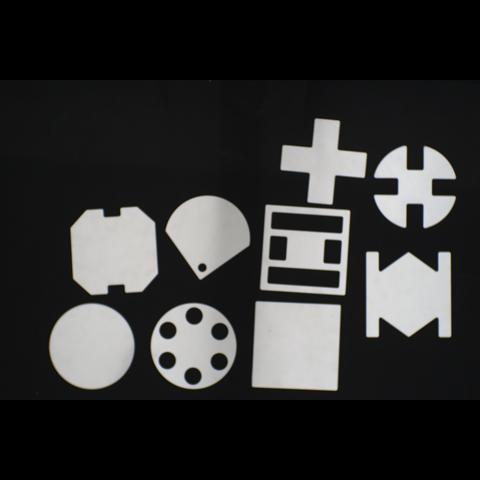

In [14]:
import torch
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection


image_path = r"D:\Test_slike\devetdijela\slika_7.jpg"
image = Image.open(image_path)
image

In [15]:


with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected 6dio with confidence 0.928 at location [148.61, 302.38, 239.91, 390.76]
Detected 5dio with confidence 0.924 at location [368.83, 140.22, 460.07, 232.26]
Detected 9dio with confidence 0.907 at location [163.38, 189.71, 253.03, 282.53]
Detected 2dio with confidence 0.899 at location [45.71, 301.37, 137.79, 390.92]
Detected 7dio with confidence 0.871 at location [255.46, 197.97, 353.95, 301.98]
Detected 4dio with confidence 0.864 at location [277.03, 113.89, 370.55, 207.32]
Detected 1dio with confidence 0.852 at location [247.38, 298.25, 345.01, 392.44]
Detected 3dio with confidence 0.851 at location [68.87, 202.99, 161.03, 298.53]
Detected 8dio with confidence 0.675 at location [362.69, 244.06, 455.31, 338.64]


In [16]:
from PIL import Image, ImageDraw, ImageFont

draw = ImageDraw.Draw(image)
font_size = 20  
font = ImageFont.truetype("arial.ttf", font_size)  

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    
    draw.rectangle((x, y, x2, y2), outline="red", width=3)
    
    text = model.config.id2label[label.item()]
    draw.text((x, y), text, fill="white", font=font)

image.show()
